# Attempt 1

In [1]:
# !pip install olmocr
# !pip install -U mlx mlx-vlm
# !pip install -U transformers

In [2]:
import base64
import urllib.request
from io import BytesIO

from mlx_vlm import apply_chat_template, generate, load
from mlx_vlm.utils import load_config, load_image
from olmocr.data.renderpdf import render_pdf_to_base64png
from olmocr.prompts import build_finetuning_prompt
from olmocr.prompts.anchor import get_anchor_text
from PIL import Image


In [3]:
model_path = "mlx-community/olmOCR-7B-0225-preview-4bit"
# model_path = "mlx-community/olmOCR-7B-0225-preview-bf16"
model, processor = load(model_path)
config = load_config(model_path)

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

In [4]:
urllib.request.urlretrieve("https://arxiv.org/pdf/2201.04234", "./paper.pdf")

('./paper.pdf', <http.client.HTTPMessage at 0x4e1adc550>)

In [5]:
# Render page 1 to an image
image_base64 = render_pdf_to_base64png("./paper.pdf", 1, target_longest_image_dim=300)

In [6]:
anchor_text = get_anchor_text("./paper.pdf", 1, pdf_engine="pdfreport", target_length=4000)
anchor_text

"Page dimensions: 612.0x792.0\n[32x232]arXiv:2201.04234v3  \\[cs.LG\\]  15 Oct 2022\n[108x195]well-known to be impossible absent further assumptions (Ben-David et al., 2010; Lipton et al., 2018).\n[108x249](Szegedy et al., 2014; Recht et al., 2019; Koh et al., 2021). Commonly, the only data available to\n[108x178]Two vital questions that remain are: (i) the precise conditions under which we can estimate a clas-\n[108x90]to estimate the accuracy on the target for a given classifier.\n[108x101]performance. Note that in this work, our focus is\n[108x112]to use unlabeled data from the target distribution, that is comparatively abundant, to predict model\n[108x123]especially if the target distribution is non-stationary. Hence, instead of using labeled data, we aim\n[108x134]ing fresh labeled data from the target distribution is prohibitively expensive and time-consuming,\n[108x145]labeled (target domain) examples and then to evaluate the model on that data. However, collect-\n[108x156]strai

In [7]:
prompt = build_finetuning_prompt(anchor_text)
prompt

"Below is the image of one page of a document, as well as some raw textual content that was previously extracted for it. Just return the plain text representation of this document as if you were reading it naturally.\nDo not hallucinate.\nRAW_TEXT_START\nPage dimensions: 612.0x792.0\n[32x232]arXiv:2201.04234v3  \\[cs.LG\\]  15 Oct 2022\n[108x195]well-known to be impossible absent further assumptions (Ben-David et al., 2010; Lipton et al., 2018).\n[108x249](Szegedy et al., 2014; Recht et al., 2019; Koh et al., 2021). Commonly, the only data available to\n[108x178]Two vital questions that remain are: (i) the precise conditions under which we can estimate a clas-\n[108x90]to estimate the accuracy on the target for a given classifier.\n[108x101]performance. Note that in this work, our focus is\n[108x112]to use unlabeled data from the target distribution, that is comparatively abundant, to predict model\n[108x123]especially if the target distribution is non-stationary. Hence, instead of usi

In [8]:
# Build the full prompt
messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/png;base64,{image_base64}"},
            },
        ],
    }
]

In [9]:
formatted_prompt = apply_chat_template(
    processor, config, messages, num_images=1,
)

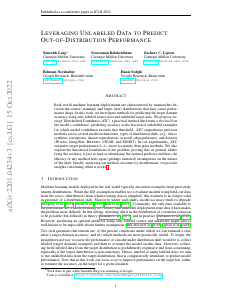

In [10]:
image = load_image(BytesIO(base64.b64decode(image_base64)))
image

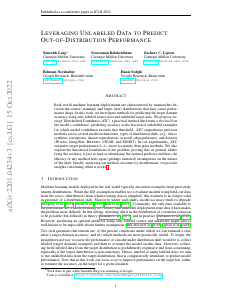

In [11]:
# Apply the chat template and processor
main_image = Image.open(BytesIO(base64.b64decode(image_base64)))
main_image

In [12]:
image.size

(232, 300)

In [13]:
main_image.size

(232, 300)

Token indices sequence length is longer than the specified maximum sequence length for this model (39350 > 32768). Running this sequence through the model will result in indexing errors


Files: <PIL.Image.Image image mode=RGB size=232x300 at 0x4E65D1B10> 

Prompt: <|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
[{'type': 'text', 'text': "Below is the image of one page of a document, as well as some raw textual content that was previously extracted for it. Just return the plain text representation of this document as if you were reading it naturally.\nDo not hallucinate.\nRAW_TEXT_START\nPage dimensions: 612.0x792.0\n[32x232]arXiv:2201.04234v3  \\[cs.LG\\]  15 Oct 2022\n[108x195]well-known to be impossible absent further assumptions (Ben-David et al., 2010; Lipton et al., 2018).\n[108x249](Szegedy et al., 2014; Recht et al., 2019; Koh et al., 2021). Commonly, the only data available to\n[108x178]Two vital questions that remain are: (i) the precise conditions under which we can estimate a clas-\n[108x90]to estimate the accuracy on the target for a given classifier.\n[108x101]performance. Note that in this work, our focus is\n[108x112]to use unl
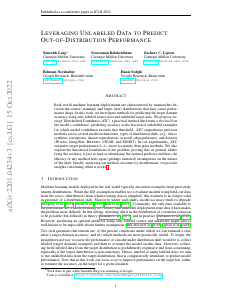

RuntimeError: [metal::malloc] Attempting to allocate 11993895936 bytes which is greater than the maximum allowed buffer size of 9663676416 bytes.

In [14]:
output = generate(model, processor, formatted_prompt, image, verbose=True, max_new_tokens=3000, max_tokens=3000)

In [ ]:
output